In [102]:
#Kalman variables
longKalman = 0.
latKalman = 0.
gainA = 0.
gainB = 0.
varianceA = 10000.
varianceB = 10000.
predictedLong = -4.
predictedLat = 53.
################################################################
#q = 5             # Tune this constant for the data type ... Lower value makes smoother.
q = 0.5             # Tune this constant for the data type
r = 400           
#r = 100            # Tune this constant for the data type ... Higher value makes smoother.
n = 200           # Number of readings to take (iterations).
################################################################
predictedVarianceA = varianceA + q
predictedVarianceB = varianceB + q

def kalmanLong(gainA, longKalman, predictedVarianceA, varianceA, predictedLong):
    gainA = predictedVarianceA/(predictedVarianceA + r)
    longKalman = predictedLong + gainA*(longValue - predictedLong)
    varianceA = (1-gainA)*predictedVarianceA
    predictedLong = longKalman
    predictedVarianceA = varianceA + q
    return [gainA, longKalman, predictedVarianceA, varianceA, predictedLong]

def kalmanLat(gainB, latKalman, predictedVarianceB, varianceB, predictedLat):
    gainB = predictedVarianceB/(predictedVarianceB + r)
    latKalman = predictedLat + gainB*(latValue - predictedLat)
    variance = (1-gainB)*predictedVarianceB
    predictedLat = latKalman
    predictedVarianceB = varianceB + q
    return [gainB, latKalman, predictedVarianceB, varianceB, predictedLat]
  

Exception in thread Thread-64:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "<ipython-input-101-d6a7294bfec7>", line 33, in run
    gpsd.next() #this will continue to loop and grab EACH set of gpsd info to clear the buffer
AttributeError: 'NoneType' object has no attribute 'next'
Exception in thread Thread-59:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "<ipython-input-91-29c8e1975733>", line 33, in run
    gpsd.next() #this will continue to loop and grab EACH set of gpsd info to clear the buffer
AttributeError: 'NoneType' object has no attribute 'next'
Exception in thread Thread-63:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "<ipython-input-99-c96bef4f993c>", line 33, in run
    gpsd.next() #this will continue to loop and grab EACH se

200...199...198...197...196...195...194...193...192...191...190...189...188...187...186...185...184...183...182...181...180...179...178...177...176...175...174...173...172...171...170...169...168...167...166...165...164...163...162...161...160...159...158...157...156...155...154...153...152...151...150...149...148...147...146...145...144...143...142...141...140...139...138...137...136...135...134...133...132...131...130...129...128...127...126...125...124...123...122...121...120...119...118...117...116...115...114...113...112...111...110...109...108...107...106...105...104...103...102...101...100...99...98...97...96...95...94...93...92...91...90...89...88...87...86...85...84...83...82...81...80...79...78...77...76...75...74...73...72...71...70...69...68...67...66...65...64...63...62...61...60...59...58...57...56...55...54...53...52...51...50...49...48...47...46...45...44...43...42...41...40...39...38...37...36...35...34...33...32...31...30...29...28...27...26...25...24...23...22...21..

Text(0, 0.5, 'Longitude')

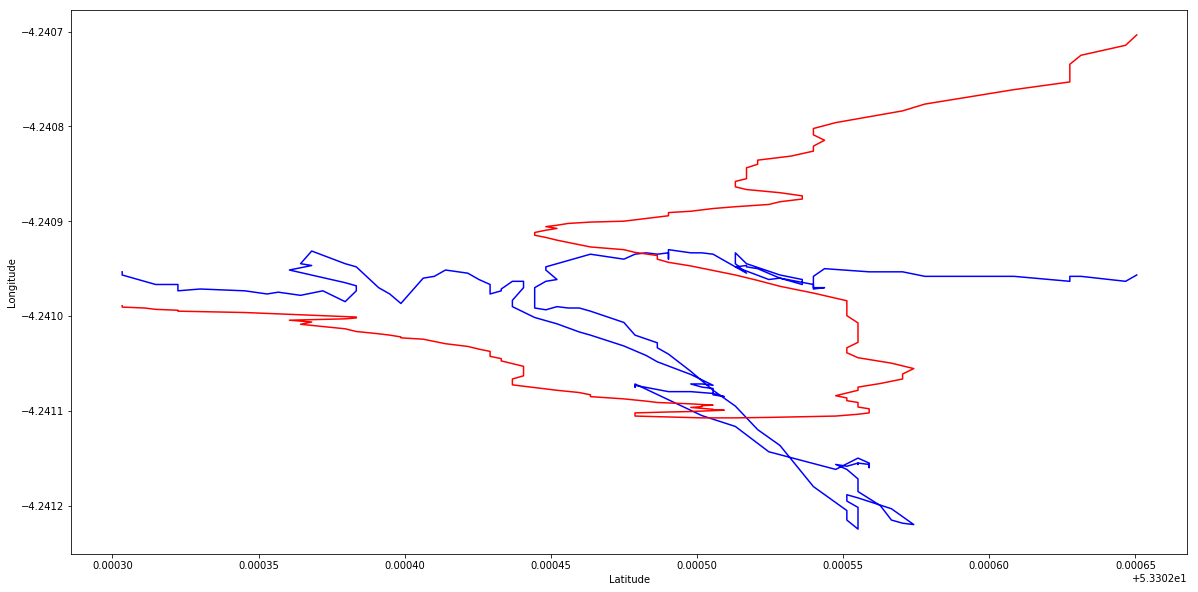

In [103]:
#! /usr/bin/python
# Written by Dan Mandle http://dan.mandle.me September 2012
# License: GPL 2.0
 
import os
from gps import *
from time import *
import time
import threading
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np
from array import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
 
gpsd = None #seting the global variable
 
os.system('clear') #clear the terminal (optional)
 
class GpsPoller(threading.Thread):
  def __init__(self):
    threading.Thread.__init__(self)
    global gpsd #bring it in scope
    gpsd = gps(mode=WATCH_ENABLE) #starting the stream of info
    self.current_value = None
    self.running = True #setting the thread running to true
 
  def run(self):
    global gpsd
    while gpsp.running:
      gpsd.next() #this will continue to loop and grab EACH set of gpsd info to clear the buffer
    
array_Lat = array('f', [])
array_Long = array('f', [])
array_LatKalman = array('f', [])
array_LongKalman = array('f', [])

if __name__ == '__main__':
  gpsp = GpsPoller() # create the thread
  try:
    gpsp.start() # start it up
    i = n
    for x in range(n):
      #It may take a second or two to get good data
      #print gpsd.fix.latitude,', ',gpsd.fix.longitude,'  Time: ',gpsd.utc
 
      os.system('clear')

      print (i, end ="...")
      i = i -1
      #print ('----------------------------------------')
      #print ('latitude    ' , gpsd.fix.latitude)
      #print ('longitude   ' , gpsd.fix.longitude)
      if x > 0:
        #print ('.............')
        #print ('latitude 1    ' , gpsd.fix.latitude)
        #print ('longitude 1  ' , gpsd.fix.longitude)
        latValue = gpsd.fix.latitude
        longValue = gpsd.fix.longitude
        #print ('')
        #print ('latitude    ' , latValue, end =", ")
        #print ('longitude   ' , longValue)
        gainA, longKalman, predictedVarianceA, varianceA, predictedLong = kalmanLong(gainA, longKalman, predictedVarianceA, varianceA, predictedLong)
        gainB, latKalman, predictedVarianceB, varianceB, predictedLat = kalmanLat(gainB, latKalman, predictedVarianceB, varianceB, predictedLat)
        #print ('latKalman    ' , latKalman, end =", ")
        #print ('longKalman   ' , longKalman)
      if x > 30:
        array_Lat.append(latValue)
        array_Long.append(longValue)
        array_LatKalman.append(latKalman)
        array_LongKalman.append(longKalman)
        
      #print ()
      #print ('time utc    ' , gpsd.utc,' + ', gpsd.fix.time)'altitude (m)' , gpsd.fix.altitude
      #print ('eps         ' , gpsd.fix.eps)
      #print ()
      #print ('epx         ' , gpsd.fix.epx)'epv         ' , gpsd.fix.epv
      #print ('ept         ' , gpsd.fix.ept)
      #print ('speed (m/s) ' , gpsd.fix.speed)
      #print ('climb       ' , gpsd.fix.climb)
      #print ('track       ' , gpsd.fix.track)
      #print ('mode        ' , gpsd.fix.mode)
      #print
      #print ('sats        ' , gpsd.satellites)
 
      time.sleep(1) #set to whatever
 
  except (KeyboardInterrupt, SystemExit): #when you press ctrl+c
    #print "\nKilling Thread..."
    gpsp.running = False
    gpsp.join() # wait for the thread to finish what it's doing
  #print "Done.\nExiting."

plt.plot(array_Lat, array_Long, color='blue')
plt.plot(array_LatKalman, array_LongKalman, color='red')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
print('Raw = BLUE',end =", ")
print('Kalman = RED')

In [10]:
#Kalman variables
#global variance 
#global predictedTemp
#global q
#global r
#global predictedVariance
#global gain
#global tempKalman
tempKalman = 0.
gain = 0.
#predictedVariance = 0.
variance = 10000.
predictedTemp = 10.
#q = 0.15
#q = 15
################################################################
q = 5             # Tune this constant for the data type ... Lower value makes smoother.
q = 0.5             # Tune this constant for the data type
r = 20            # PT100
#r = 100            # Tune this constant for the data type ... Higher value makes smoother.
n = 200           # Number of readings to take (iterations).
################################################################
predictedVariance = variance + q

print(predictedVariance)

def kalman(gain, tempKalman, predictedVariance, variance, predictedTemp):
    gain = predictedVariance/(predictedVariance + r)
    tempKalman = predictedTemp + gain*(tempPT100 - predictedTemp)
    #tempKalman = predictedTemp + gain*(tempExt - predictedTemp)
    #tempKalman = predictedTemp + gain*(tempDHT22 - predictedTemp)
    variance = (1-gain)*predictedVariance
    predictedTemp = tempKalman
    predictedVariance = variance + q
    return [gain, tempKalman, predictedVariance, variance, predictedTemp]
    

10000.5


..... PROCESSING .....199..198..197..196..195..194..193..192..191..190..189..188..187..186..185..184..183..182..181..180..179..178..177..176..175..174..173..172..171..170..169..168..167..166..165..164..163..162..161..160..159..158..157..156..155..154..153..152..151..150..149..148..147..146..145..144..143..142..141..140..139..138..137..136..135..134..133..132..131..130..129..128..127..126..ERROR CORRECTED!..125..124..123..122..121..120..119..118..117..116..115..114..113..112..111..110..109..108..107..106..105..104..103..102..101..100..99..98..97..96..95..94..93..92..91..90..89..88..87..86..85..84..83..82..81..80..79..78..77..76..75..74..73..72..71..70..69..68..67..66..65..64..63..62..61..60..59..58..57..56..55..54..53..52..51..50..49..48..47..46..45..44..43..42..41..40..39..38..37..36..35..34..33..32..31..30..29..28..27..26..25..24..23..22..21..20..19..18..17..16..15..14..13..12..11..10..9..8..7..6..5..4..ERROR CORRECTED!..3..2..1..0..
PT100 = GREEN
PT100Kalman = RED
DS18B20 = ORANGE
DH

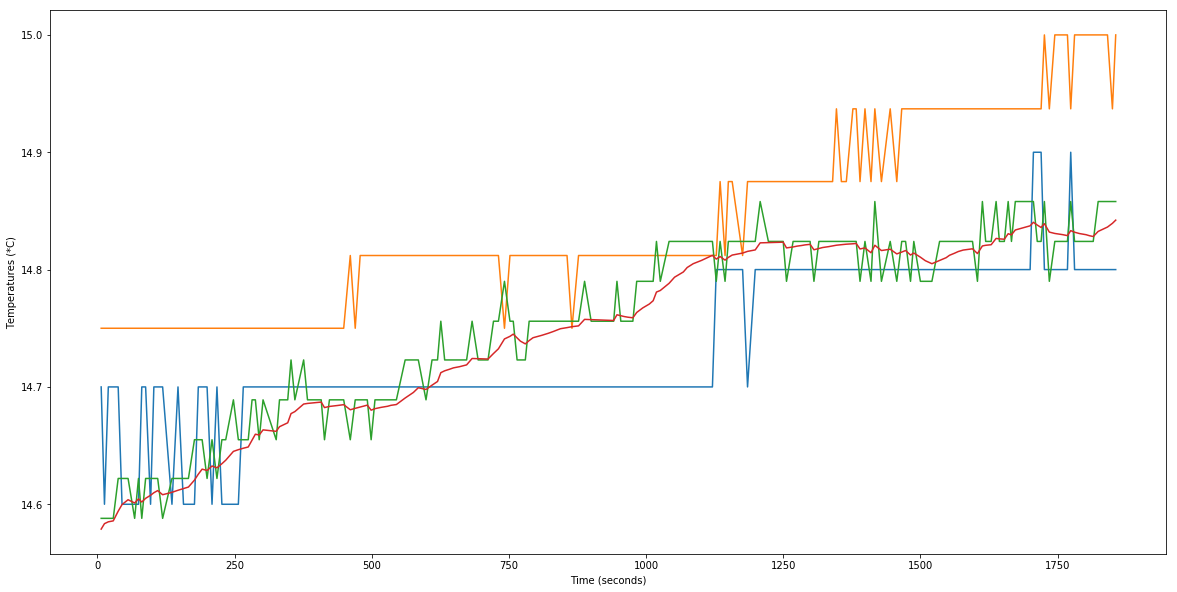

In [11]:
import datetime
import time
import Adafruit_DHT
import board
import busio
import digitalio
import adafruit_max31865
from w1thermsensor import W1ThermSensor


# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np
from array import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

ds18b20Sensor = W1ThermSensor()
DHT22Sensor = Adafruit_DHT.DHT22
DHTpin = 16

# Initialize SPI bus and sensor.
spi = busio.SPI(board.SCK, MOSI=board.MOSI, MISO=board.MISO)
cs = digitalio.DigitalInOut(board.D5)  # Chip select of the MAX31865 board.
sensor = adafruit_max31865.MAX31865(spi, cs)
# Note you can optionally provide the thermocouple RTD nominal, the reference
# resistance, and the number of wires for the sensor (2 the default, 3, or 4)
# with keyword args:
sensor = adafruit_max31865.MAX31865(spi, cs, rtd_nominal=100, ref_resistor=430.0, wires=4)

now = datetime.datetime.now()
#timeString = now.strftime("%Y-%m-%d %H:%M")
timeStringS = now.strftime("%S")
timeStringM = now.strftime("%M")
timeStringH = now.strftime("%H")
initialIntTimeString = int(timeStringS) + (int(timeStringM) * 60) + (int(timeStringH) * 60 * 60)

print('..... PROCESSING .....',end ="")

def getSensorData():
    #global timeString
    #global humLab
    global tempExt
    #global tempLab
    global tempPT100
    global tempDHT22
    global intTimeString

    now = datetime.datetime.now()
    #timeString = now.strftime("%Y-%m-%d %H:%M")
    timeStringH = now.strftime("%H")
    timeStringS = now.strftime("%S")
    timeStringM = now.strftime("%M")
    intTimeString = int(timeStringS) + (int(timeStringM) * 60) + (int(timeStringH) * 60 * 60)- initialIntTimeString
    
    tempExt = round(ds18b20Sensor.get_temperature(), 8)
    humDHT, tempDHT = Adafruit_DHT.read_retry(DHT22Sensor, DHTpin)
    if (humDHT is not None) and (tempDHT is not None):
        hum = round (humDHT,3)
        tempDHT22 = round (tempDHT, 8)
        
        
    
    tempPT100 = round (sensor.temperature,3)
    # Print the value.
    #print('PT100 sensor = {0:0.5f}*C'.format(tempPT100))
    #print('DS18B20 Sensor = {}*C'.format(tempExt))
    #print('DHT22 Sensor = {}*C'.format(tempDHT22))
    #print()
    time.sleep(5.0)

    
array_DHT22 = array('f', [])
array_DS18B20 = array('f', [])
array_PT100 = array('f', [])
array_PT100Kalman = array('f', [])
array_Time = array('i', [])

getSensorData()  # Warm up the sensors with one off reading

#n = 200      #Set the number of iterations 
i = n
for x in range(n):
    try:
        getSensorData()
        #filter out crappy readings on DHT22 ... TODO: improve eg for readings close to zero
        if (x == 0):
            previousDHT22Temp = tempDHT22
        if ((tempDHT22 > previousDHT22Temp*1.2) or (tempDHT22 < previousDHT22Temp*0.8)):
            tempDHT22 = previousDHT22Temp
            print('ERROR CORRECTED!', end ="..")
        previousDHT22Temp = tempDHT22
        #end of filter
        
        gain, tempKalman, predictedVariance, variance, predictedTemp = kalman(gain, tempKalman, predictedVariance, variance, predictedTemp)
        
        array_DHT22.append(tempDHT22)
        array_DS18B20.append(tempExt)
        array_PT100.append(tempPT100)
        array_PT100Kalman.append(tempKalman)
        array_Time.append(intTimeString)
        i = i -1
        print(i, end ="..")

    except RuntimeError as error:
        # Errors happen fairly often, DHT's are hard to read, just keep going
        print(error.args[0])

plt.plot(array_Time, array_DHT22)
plt.plot(array_Time, array_DS18B20)
plt.plot(array_Time, array_PT100)
plt.plot(array_Time, array_PT100Kalman)
plt.xlabel('Time (seconds)')
plt.ylabel('Temperatures (*C)')

print()
print('PT100 = GREEN')
print('PT100Kalman = RED')
print('DS18B20 = ORANGE')
print('DHT22 = BLUE')
print('r = ', end ="")
print(r, end =", ")
print('q = ', end ="")
print(q)

In [ ]:


# 1D Kalman Filter

Now, you're ready to implement a 1D Kalman Filter by putting all these steps together. Let's take the case of a robot that moves through the world. As a robot moves through the world it locates itself by performing a cycle of:
1. sensing and performing a measurement update and
2. moving and performing a motion update

You've programmed each of these steps individually, so now let's combine them in a cycle!

After implementing this filter, you should see that you can go from a very uncertain location Gaussian to a more and more certain Gaussian, as pictured below. The code in this notebooks is really just a simplified version of the Kalman filter that runs in the Google self-driving car that is used to track surrounding vehicles and other objects.

<img src='images/gaussian_updates.png' height=70% width=70% />

---

Below is our usual Gaussian equation and imports.

In [2]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np

# gaussian function
def f(mu, sigma2, x):
    ''' f takes in a mean and squared variance, and an input x
       and returns the gaussian value.'''
    coefficient = 1.0 / sqrt(2.0 * pi *sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential
 

You've also been given the complete `update` code that performs a parameter update when an initial belief and new measurement information are merged. And the complete `predict` code that performs an update to a Gasuuain after a motion is incorporated.

In [3]:
# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]

In [4]:
update(20,9,30,3)

[27.5, 2.25]

### QUIZ: For the given measurements and motions, write complete 1D Kalman filter code that loops through all of these in order.

Your complete code should look at sensor measurements then motions in that sequence until all updates are done!

### Initial Uncertainty

You'll see that you are given initial parameters below, and this includes and nitial location estimation, `mu` and squared variance, `sig`. Note that the initial estimate is set to the location 0, and the variance is extremely large; this is a state of high confusion much like the *uniform* distribution we used in the histogram filter. There are also values given for the squared variance associated with the sensor measurements and the motion, since neither of those readings are perfect, either.

You should see that even though the initial estimate for location (the initial `mu`) is far from the first measurement, it should catch up fairly quickly as you cycle through measurements and motions.

In [17]:
# measurements for mu and motions, U
measurements = [5., 6., 7., 9., 10.]
motions = [1., 1., 2., 10., 10.]

# initial parameters
measurement_sig = 400.
motion_sig = 2.
mu = 100.
sig = 1000000.


## TODO: Loop through all measurements/motions
# this code assumes measurements and motions have the same length
# so their updates can be performed in pairs
for n in range(len(measurements)):
    # measurement update, with uncertainty
    mu, sig = update(mu, sig, measurements[n], measurement_sig)
    print('Update: [{}, {}]'.format(mu, sig))
    # motion update, with uncertainty
    mu, sig = predict(mu, sig, motions[n], motion_sig)
    print('Predict: [{}, {}]'.format(mu, sig))

    
# print the final, resultant mu, sig
print('\n')
print('Final result: [{}, {}]'.format(mu, sig))

Update: [5.037984806077569, 399.8400639744102]
Predict: [6.037984806077569, 401.8400639744102]
Update: [6.018948819239235, 200.45896034809977]
Predict: [7.018948819239235, 202.45896034809977]
Update: [7.012580985916974, 134.42174400136358]
Predict: [9.012580985916973, 136.42174400136358]
Update: [9.009381413827953, 101.72722901480057]
Predict: [19.009381413827953, 103.72722901480057]
Update: [17.154174636498148, 82.36777608204527]
Predict: [27.154174636498148, 84.36777608204527]


Final result: [27.154174636498148, 84.36777608204527]


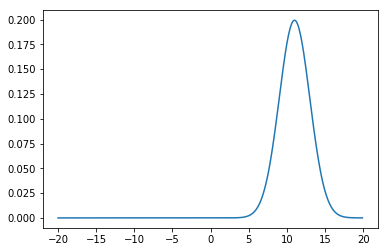

In [8]:
## Print out and display the final, resulting Gaussian 
# set the parameters equal to the output of the Kalman filter result
mu = mu
sigma2 = sig

# define a range of x values
x_axis = np.arange(-20, 20, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(f(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)

### Plot a Gaussian

Plot a Gaussian by looping through a range of x values and creating a resulting list of Gaussian values, `g`, as shown below. You're encouraged to see what happens if you change the values of `mu` and `sigma2`.

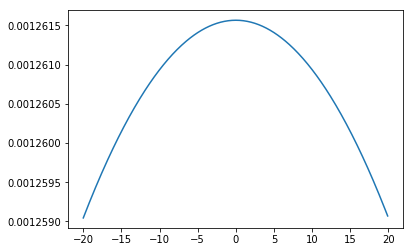

In [10]:
# display the *initial* gaussian over a range of x values
# define the parameters
mu = 0
sigma2 = 100000

# define a range of x values
x_axis = np.arange(-20, 20, 0.1)

# create a corresponding list of gaussian values
g = []
for x in x_axis:
    g.append(f(mu, sigma2, x))

# plot the result 
plt.plot(x_axis, g)